# Showcases

The goal of this notebook is to anlyze and compare the results and context underlying relations for Naive RAG and for the Datamodels (knowing the groundtruth). This will be done with the following sections:
- Selection of showcases
- Definition of comparison methods
- Showcase 1: Good Datamodels/Bad RAG
- Showcase 2: Good Datamodels/Good RAG
- Showcase 3: Bad Datamodels/Good RAG
- Showcase 4: Bad Datamodels/Bad RAG

In [16]:
import numpy as np
import polars as pl 
import seaborn as sns
import matplotlib.pyplot as plt
from dmcr.evaluators import Rouge_L_evaluator
import json
import random
from utils.set_random_seed import set_random_seed
from typing import Any


DATA_PATH = "experiments_5191"
set_random_seed(42)

## Showcases Selection

The goal of this section is to compare the results in Rouge-L evaluation between naive RAG and Datamodels and cherry-pick the four showcases needed

In [2]:
evaluator = Rouge_L_evaluator()
df = pl.read_ipc(f"{DATA_PATH}/questions.feather").with_row_index("idx")
datamodels_generations = json.load(open(f"{DATA_PATH}/generations/datamodels_generations.json", "r"))
rag_generations = json.load(open(f"{DATA_PATH}/generations/rag_generations.json", "r"))
wiki = pl.read_ipc("../../data/wiki_dump2018_nq_open/processed/wiki.feather")

In [3]:
df.head()

idx,example_id,question,answers,text,idx_gold_in_corpus
u32,i64,str,list[str],str,i64
0,-7245946444921765780,"""who is the minister of state f…","[""Dr. Harsh Vardhan""]","""The Ministry of Environment , …",20994123
1,3272842107199468512,"""who's the dad of blair waldorf…","[""Chuck""]","""In the final season , Blair re…",21029231
2,491992093618591252,"""who plays the robot in unbreak…","[""Julie Tice - Bubolz""]","""Julie Tice - Bubolz as Yuko , …",21028554
3,-8291094268892970785,"""who is the current mayor of lo…","[""Eric Garcetti""]","""The Mayor of the City of Los A…",21028222
4,7328747897271045145,"""who played jason bateman's sis…","[""Missy Francis""]","""Name Seasons No. of episodes P…",20992518


In [4]:

rag_arr = np.array([rag_generations[str(i)][0] for i in range(50)])
dat_arr = np.array([datamodels_generations[str(i)][0] for i in range(50)])
rag_evals = evaluator.evaluate(np.array([[df["answers"][i][0]] for i in range(50)]),rag_arr)
dat_evals = evaluator.evaluate(np.array([[df["answers"][i][0]] for i in range(50)]),dat_arr)
df = df.with_columns(
    pl.Series("rag_evals", rag_evals).cast(pl.Float32).alias("rag_evals"),
    pl.Series("dat_evals", dat_evals).cast(pl.Float32).alias("dat_evals"),
    pl.Series("rag_gen", rag_arr),
    pl.Series("datamodels_gen", dat_arr)
)
df.head()

idx,example_id,question,answers,text,idx_gold_in_corpus,rag_evals,dat_evals,rag_gen,datamodels_gen
u32,i64,str,list[str],str,i64,f32,f32,str,str
0,-7245946444921765780,"""who is the minister of state f…","[""Dr. Harsh Vardhan""]","""The Ministry of Environment , …",20994123,0.0,0.0,"""Brune Poirson""","""Denis Naughten."""
1,3272842107199468512,"""who's the dad of blair waldorf…","[""Chuck""]","""In the final season , Blair re…",21029231,0.0,1.0,"""There is no mention of Blair W…","""Chuck."""
2,491992093618591252,"""who plays the robot in unbreak…","[""Julie Tice - Bubolz""]","""Julie Tice - Bubolz as Yuko , …",21028554,0.0,0.0,"""Tituss Burgess""","""Titus Andromedon"""
3,-8291094268892970785,"""who is the current mayor of lo…","[""Eric Garcetti""]","""The Mayor of the City of Los A…",21028222,1.0,1.0,"""Eric Garcetti""","""Eric Garcetti"""
4,7328747897271045145,"""who played jason bateman's sis…","[""Missy Francis""]","""Name Seasons No. of episodes P…",20992518,0.0,0.0,"""Addison Timlin""","""Leslie Landon"""


In [64]:
#### questions with gold
questions_with_gold = []
for i in range(50):
    gold_idx = df[i]["idx_gold_in_corpus"].to_numpy()[0]
    rag_indexes = json.load(open(f"{DATA_PATH}/retrieval/rag_retrieval_indexes.json", "r"))[str(i)]
    for j in range(100):
        if gold_idx == rag_indexes[j]:
            questions_with_gold.append(i)
            break

In [65]:
######## Choose showcase 1
sc1 = (
    df
    .filter(pl.col("dat_evals") > pl.col("rag_evals"))
    .filter(pl.col("idx").is_in(questions_with_gold))
    .sample(n=1, seed=random.randint(0, 100))
)
sc1

idx,example_id,question,answers,text,idx_gold_in_corpus,rag_evals,dat_evals,rag_gen,datamodels_gen
u32,i64,str,list[str],str,i64,f32,f32,str,str
14,-8184010537833567123,"""when does percy jackson the ti…","[""May 1 , 2007""]","""The Titan 's Curse was publish…",21032421,0.0,1.0,"""2009""","""May 1, 2007"""


In [66]:
sc2 = (
    df
    .filter(pl.col("dat_evals") == pl.col("rag_evals"))
    .filter(pl.col("dat_evals") == 1)
    .filter(pl.col("idx").is_in(questions_with_gold))
    .sample(n=1, seed=random.randint(0, 100))
)
sc2

idx,example_id,question,answers,text,idx_gold_in_corpus,rag_evals,dat_evals,rag_gen,datamodels_gen
u32,i64,str,list[str],str,i64,f32,f32,str,str
3,-8291094268892970785,"""who is the current mayor of lo…","[""Eric Garcetti""]","""The Mayor of the City of Los A…",21028222,1.0,1.0,"""Eric Garcetti""","""Eric Garcetti"""


In [67]:
sc3 = (
    df
    .filter(pl.col("dat_evals") < pl.col("rag_evals"))
    .filter((pl.col("rag_evals")-pl.col("dat_evals")) > 0.5)
    .filter(pl.col("idx").is_in(questions_with_gold))
    .sample(n=1, seed=random.randint(0, 100))
)
sc3

idx,example_id,question,answers,text,idx_gold_in_corpus,rag_evals,dat_evals,rag_gen,datamodels_gen
u32,i64,str,list[str],str,i64,f32,f32,str,str
24,-4557872761351747229,"""how many schools have won a na…","[""7""]","""The following table contains t…",21028059,1.0,0.0,"""7""","""30"""


In [68]:
sc3 = (
    df
    .filter(pl.col("dat_evals") == pl.col("rag_evals"))
    .filter(pl.col("dat_evals") == 0)
    .filter(pl.col("idx").is_in(questions_with_gold))
    .sample(n=1, seed=random.randint(0, 100))
)
sc3

idx,example_id,question,answers,text,idx_gold_in_corpus,rag_evals,dat_evals,rag_gen,datamodels_gen
u32,i64,str,list[str],str,i64,f32,f32,str,str
9,-3280963377494034044,"""who are the current justices o…","[""Samuel Alito"", ""Ruth Bader Ginsburg"", … ""Clarence Thomas""]","""This article is part of the se…",21031082,0.0,0.0,"""The current justices of the U.…","""John Roberts, Clarence Thomas,…"


## Definition of comparison methods

### Visualization RAG ranking to Datamodels ranking

This function creates a visualization to understand what postion of list of tuples the first value is assigned for the second value. The idea is to understand where the 16 first retrieved elements of the RAG receveis for the Datamodels

In [8]:
def plot_rag_rank_to_datamodels_rank(data, title="Connected Data Visualization", k=16):
    """
    Visualizes connections between two columns of data from a list of tuples.

    Each column is sorted independently, and lines are drawn to connect the
    items based on their original pairing in the input tuples.

    Args:
        data (list of tuples): A list of tuples, e.g., [('A', 1), ('B', 2)].
        title (str): The title for the plot.
    """
    if not data:
        print("Input data is empty. Nothing to plot.")
        return

    # --- 1. Separate and Sort Data ---
    # Extract the first and second elements from each tuple into separate lists.
    left_column_data = [item[0] for item in data]
    right_column_data = [item[1] for item in data]

    # Sort each list independently.
    # We use a custom key for sorting to handle mixed types (numbers and strings).
    sorted_left = sorted(left_column_data)
    sorted_right = sorted(right_column_data)

    # --- 2. Create Mappings for Positions ---
    # Create a dictionary to map each value to its vertical position (index) in the sorted list.
    # This is crucial for knowing where to draw the text and the ends of the lines.
    left_pos = {value: i for i, value in enumerate(sorted_left)}
    right_pos = {value: i for i, value in enumerate(sorted_right)}

    # --- 3. Create the Plot ---
    fig, ax = plt.subplots(figsize=(8, 6))

    # Set x-coordinates for the left and right columns.
    x_left, x_right = 0, 1

    # --- 4. Plot the Column Items ---
    # Display the sorted values as text on the plot.
    for value, y in left_pos.items():
        ax.text(x_left, y, f"  {value}", va='center', ha='left', fontsize=12, fontweight='bold')

    for value, y in right_pos.items():
        ax.text(x_right, y, f"{value}  ", va='center', ha='right', fontsize=12, fontweight='bold')

    # --- 5. Draw the Connecting Lines ---
    # Iterate through the *original* data to draw lines between corresponding pairs.
    for left_val, right_val in data:
        # Get the vertical position (y-coordinate) for each value in the pair.
        y1 = left_pos[left_val]
        y2 = right_pos[right_val]

        line_color = 'y-' if right_val < k else 'c-'
        
        # Plot a line between the two points.
        ax.plot([x_left, x_right], [y1, y2], line_color, alpha=0.6, linewidth=2)

    # --- 6. Customize the Plot's Appearance ---
    # Set the title and remove unnecessary axes and spines for a cleaner look.
    ax.set_title(title, fontsize=16, pad=20)
    
    # Set limits to provide padding around the content.
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-1, len(data))
    
    # Hide the axes ticks and labels.
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Hide the plot borders (spines).
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Invert the y-axis so the first item is at the top.
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

### Gold ranking

This metrics has the goal to capture the position of the gold document for each retrieval method and plot it as a barploit

In [51]:
def gold_ranking_plot(rag_r: list[tuple[Any, int]], datamodels_r: list[tuple[Any, int]], gold_idx: int):
    """
    Finds values in tuples RAG and Datamodels associated with the gold index documenter and creates a bar plot.

    This function searches through a list of tuples "rag_r" and a list of tuples "datamodels_r".
    For each list, it looks for a tuple where the second element matches the integer "gold_idx".
    It retrieves the first element from those matching tuples. Finally, it generates
    a seaborn bar plot comparing the two retrieved values.

    Args:
        rag_r (List[Tuple[Any, int]]): The first list of tuples to search.
        datamodels_r (List[Tuple[Any, int]]): The second list of tuples to search.
        gold_idx (int): The integer to match in the second position of the tuples.
    """
    val_rag = None
    val_datamodels = None

    # Search for the value in the first tuple list (rag_r)
    # This uses a generator expression within next() for efficiency.
    # It stops as soon as a match is found.
    val_rag = next((item[0]+1 for item in rag_r if item[1] == gold_idx), 0)
    val_datamodels = next((item[0]+1 for item in datamodels_r if item[1] == gold_idx), 0)

    # --- Plotting ---
    # Prepare data for seaborn
    categories = ["RAG", "Datamodels"]
    values = [val_rag, val_datamodels]
    print(val_rag, val_datamodels)
    
    # Check if retrieved values are numeric for plotting
    if not all(isinstance(v, (int, float)) for v in values):
        print("Error: The retrieved values must be numeric to be plotted.")
        return

    # Create the plot
    plt.figure(figsize=(8, 6)) # Set the figure size for better readability
    sns.set_style("whitegrid") # Set a nice style
    
    barplot = sns.barplot(x=categories, y=values, palette=["#4c72b0", "#ff7f0e"]) # Blue and Orange colors

    # Add titles and labels for clarity
    plt.title(f'Comparison of Values for Index {gold_idx}', fontsize=16)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Retrieved Value', fontsize=12)
    
    # Add value labels on top of the bars
    for index, value in enumerate(values):
        plt.text(index, value + 0.05 * max(values), str(round(value, 2)), ha='center', va='bottom')

    # Display the plot
    plt.show()

## Showcase 1: Good Datamodels/Bad RAG



In [69]:
rag_indexes = json.load(open(f"{DATA_PATH}/retrieval/rag_retrieval_indexes.json", "r"))["14"]
datamodels_indexes = json.load(open(f"{DATA_PATH}/retrieval/size_2000_indexes.json", "r"))["14"]
rag_tuple = [(i, rag_indexes[i]) for i in range(len(rag_indexes))]
datamodels_tuple = [(100-i, datamodels_indexes[i]) for i in range(len(datamodels_indexes))]
joined_tuple = []
for i in range(len(rag_tuple)):
    for j in range(len(datamodels_tuple)):
        if rag_tuple[i][1] == datamodels_tuple[j][1]:
            joined_tuple.append((rag_tuple[i][0], datamodels_tuple[j][0]))
joined_tuple[:4]


[(0, 7), (1, 9), (2, 2), (3, 4)]

In [87]:
df[14]

idx,example_id,question,answers,text,idx_gold_in_corpus,rag_evals,dat_evals,rag_gen,datamodels_gen
u32,i64,str,list[str],str,i64,f32,f32,str,str
14,-8184010537833567123,"""when does percy jackson the ti…","[""May 1 , 2007""]","""The Titan 's Curse was publish…",21032421,0.0,1.0,"""2009""","""May 1, 2007"""


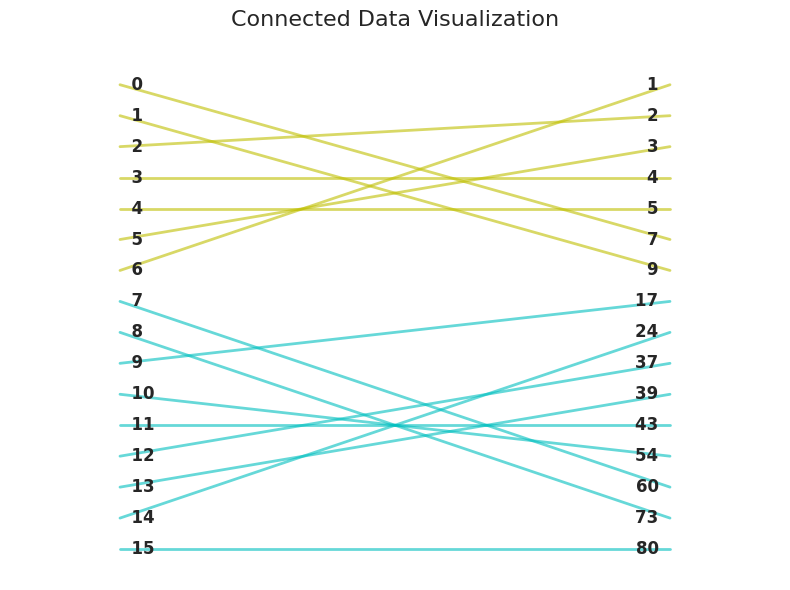

In [71]:
plot_rag_rank_to_datamodels_rank(joined_tuple[:16])

4 5


/tmp/ipykernel_2560379/1646580960.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=categories, y=values, palette=["#4c72b0", "#ff7f0e"]) # Blue and Orange colors


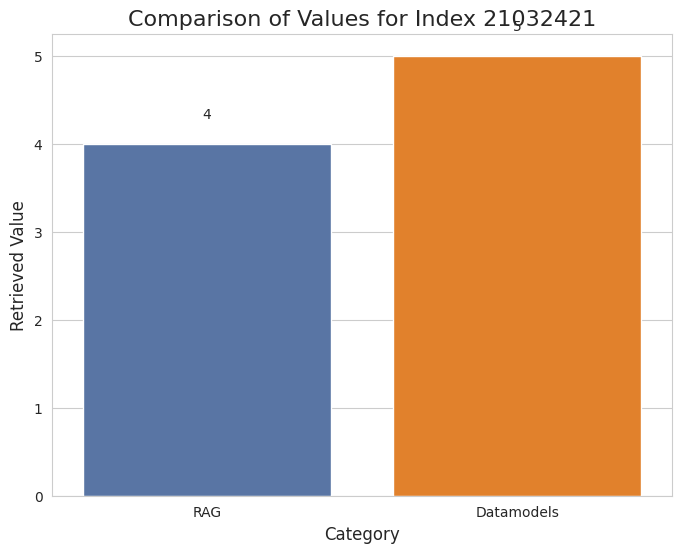

In [72]:
gold_idx = df[14]["idx_gold_in_corpus"].to_numpy()[0]
gold_ranking_plot(rag_tuple, datamodels_tuple, gold_idx)

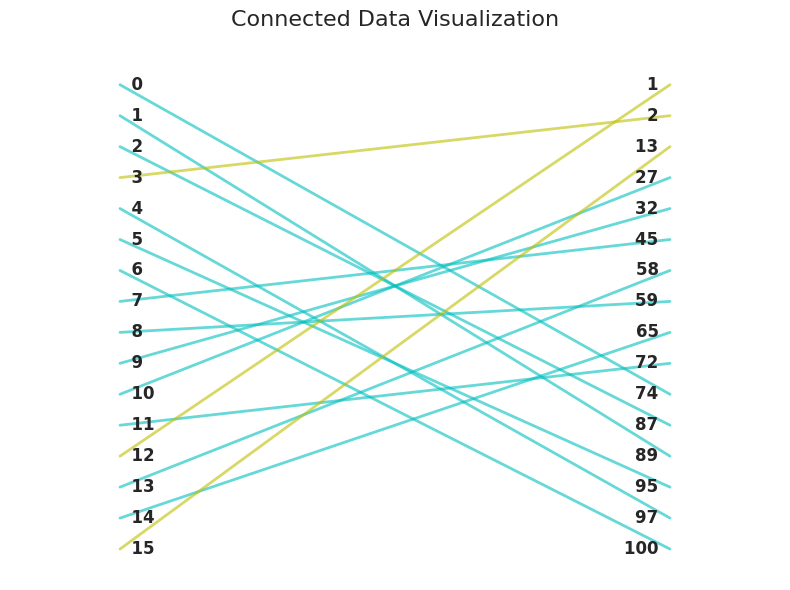

In [88]:
rag_indexes = json.load(open(f"{DATA_PATH}/retrieval/rag_retrieval_indexes.json", "r"))["18"]
datamodels_indexes = json.load(open(f"{DATA_PATH}/retrieval/size_2000_indexes.json", "r"))["18"]
rag_tuple = [(i, rag_indexes[i]) for i in range(len(rag_indexes))]
datamodels_tuple = [(100-i, datamodels_indexes[i]) for i in range(len(datamodels_indexes))]
joined_tuple = []
for i in range(len(rag_tuple)):
    for j in range(len(datamodels_tuple)):
        if rag_tuple[i][1] == datamodels_tuple[j][1]:
            joined_tuple.append((rag_tuple[i][0], datamodels_tuple[j][0]))
plot_rag_rank_to_datamodels_rank(joined_tuple[:16])

## Showcase 2: Good Datamodels/Bad RAG


In [73]:
rag_indexes = json.load(open(f"{DATA_PATH}/retrieval/rag_retrieval_indexes.json", "r"))["3"]
datamodels_indexes = json.load(open(f"{DATA_PATH}/retrieval/size_2000_indexes.json", "r"))["3"]
rag_tuple = [(i, rag_indexes[i]) for i in range(len(rag_indexes))]
datamodels_tuple = [(100-i, datamodels_indexes[i]) for i in range(len(datamodels_indexes))]
joined_tuple = []
for i in range(len(rag_tuple)):
    for j in range(len(datamodels_tuple)):
        if rag_tuple[i][1] == datamodels_tuple[j][1]:
            joined_tuple.append((rag_tuple[i][0], datamodels_tuple[j][0]))
joined_tuple[:4]

[(0, 1), (1, 67), (2, 5), (3, 3)]

In [74]:
df[3]

idx,example_id,question,answers,text,idx_gold_in_corpus,rag_evals,dat_evals,rag_gen,datamodels_gen
u32,i64,str,list[str],str,i64,f32,f32,str,str
3,-8291094268892970785,"""who is the current mayor of lo…","[""Eric Garcetti""]","""The Mayor of the City of Los A…",21028222,1.0,1.0,"""Eric Garcetti""","""Eric Garcetti"""


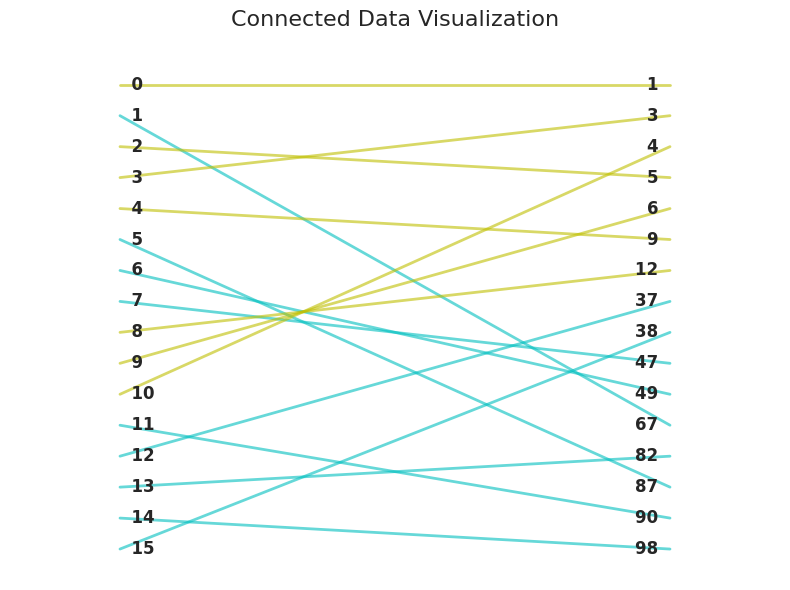

In [75]:
plot_rag_rank_to_datamodels_rank(joined_tuple[:16])

4 4


/tmp/ipykernel_2560379/1646580960.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=categories, y=values, palette=["#4c72b0", "#ff7f0e"]) # Blue and Orange colors


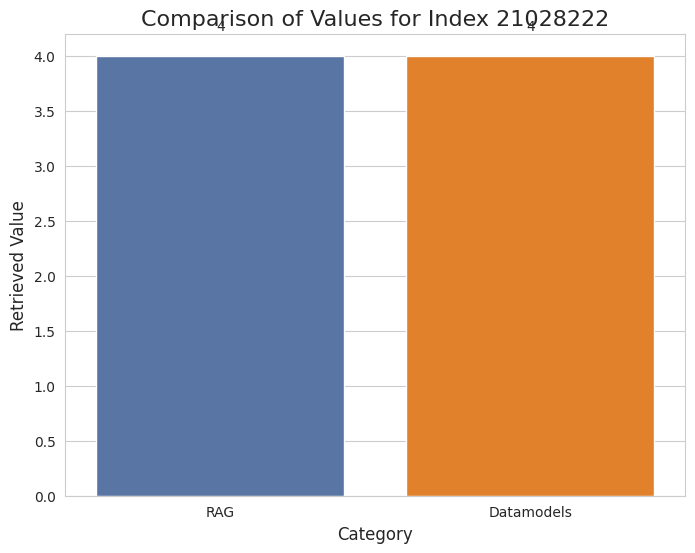

In [76]:
gold_idx = df[3]["idx_gold_in_corpus"].to_numpy()[0]
gold_ranking_plot(rag_tuple, datamodels_tuple, gold_idx)

## Showcase 3: Bad Datamodels/Good RAG

In [77]:
rag_indexes = json.load(open(f"{DATA_PATH}/retrieval/rag_retrieval_indexes.json", "r"))["24"]
datamodels_indexes = json.load(open(f"{DATA_PATH}/retrieval/size_2000_indexes.json", "r"))["24"]
rag_tuple = [(i, rag_indexes[i]) for i in range(len(rag_indexes))]
datamodels_tuple = [(100-i, datamodels_indexes[i]) for i in range(len(datamodels_indexes))]
joined_tuple = []
for i in range(len(rag_tuple)):
    for j in range(len(datamodels_tuple)):
        if rag_tuple[i][1] == datamodels_tuple[j][1]:
            joined_tuple.append((rag_tuple[i][0], datamodels_tuple[j][0]))
joined_tuple[:4]

[(0, 1), (1, 80), (2, 100), (3, 10)]

In [82]:
df[24]

idx,example_id,question,answers,text,idx_gold_in_corpus,rag_evals,dat_evals,rag_gen,datamodels_gen
u32,i64,str,list[str],str,i64,f32,f32,str,str
24,-4557872761351747229,"""how many schools have won a na…","[""7""]","""The following table contains t…",21028059,1.0,0.0,"""7""","""30"""


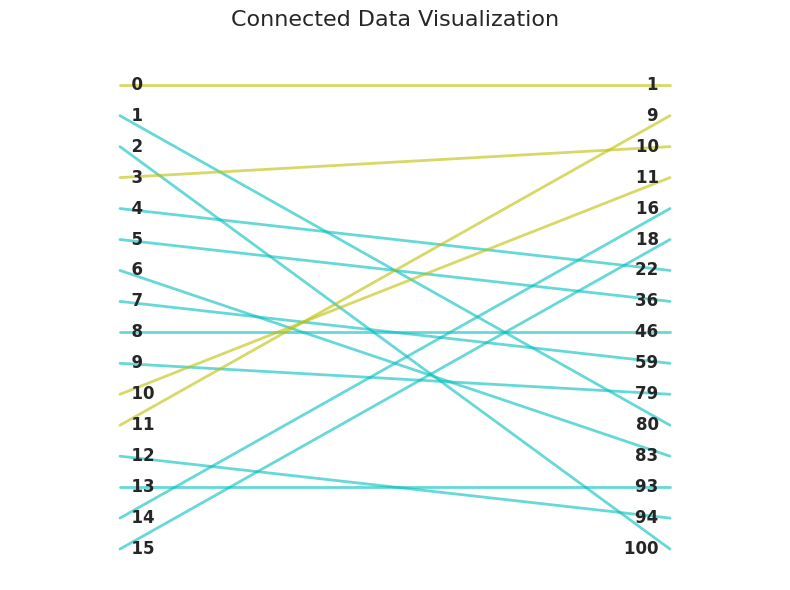

In [79]:
plot_rag_rank_to_datamodels_rank(joined_tuple[:16])

4 11


/tmp/ipykernel_2560379/1646580960.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=categories, y=values, palette=["#4c72b0", "#ff7f0e"]) # Blue and Orange colors


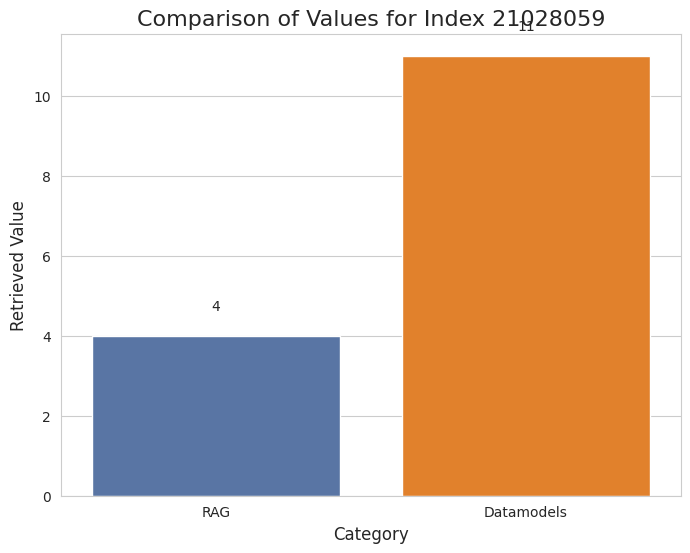

In [81]:
gold_idx = df[24]["idx_gold_in_corpus"].to_numpy()[0]
gold_ranking_plot(rag_tuple, datamodels_tuple, gold_idx)

## Showcase 4: RAG Bad/ Datamodels Bad

In [83]:
rag_indexes = json.load(open(f"{DATA_PATH}/retrieval/rag_retrieval_indexes.json", "r"))["9"]
datamodels_indexes = json.load(open(f"{DATA_PATH}/retrieval/size_2000_indexes.json", "r"))["9"]
rag_tuple = [(i, rag_indexes[i]) for i in range(len(rag_indexes))]
datamodels_tuple = [(100-i, datamodels_indexes[i]) for i in range(len(datamodels_indexes))]
joined_tuple = []
for i in range(len(rag_tuple)):
    for j in range(len(datamodels_tuple)):
        if rag_tuple[i][1] == datamodels_tuple[j][1]:
            joined_tuple.append((rag_tuple[i][0], datamodels_tuple[j][0]))
joined_tuple[:4]

[(0, 2), (1, 3), (2, 13), (3, 26)]

In [84]:
df[9]

idx,example_id,question,answers,text,idx_gold_in_corpus,rag_evals,dat_evals,rag_gen,datamodels_gen
u32,i64,str,list[str],str,i64,f32,f32,str,str
9,-3280963377494034044,"""who are the current justices o…","[""Samuel Alito"", ""Ruth Bader Ginsburg"", … ""Clarence Thomas""]","""This article is part of the se…",21031082,0.0,0.0,"""The current justices of the U.…","""John Roberts, Clarence Thomas,…"


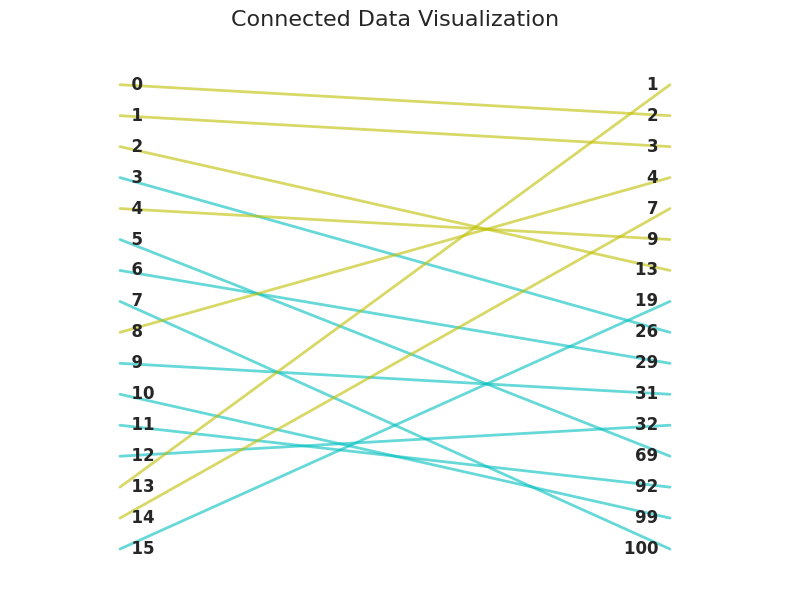

In [85]:
plot_rag_rank_to_datamodels_rank(joined_tuple[:16])

5 10


/tmp/ipykernel_2560379/1646580960.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=categories, y=values, palette=["#4c72b0", "#ff7f0e"]) # Blue and Orange colors


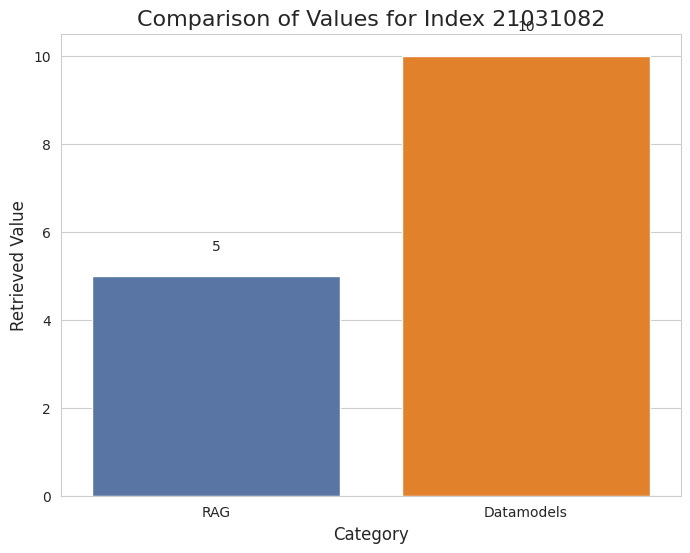

In [86]:
gold_idx = df[9]["idx_gold_in_corpus"].to_numpy()[0]
gold_ranking_plot(rag_tuple, datamodels_tuple, gold_idx)